# CYBERML Project 2025-2026
## IoT Intrusion Detection and Attack Analysis

### Objectives:
1. **Classification and Anomaly Detection** for tracking attacks
2. **Adversarial Attacks** against classification (bonus)

### Dataset: CIC IoT-DIAD 2024
Source: https://www.unb.ca/cic/datasets/iot-diad-2024.html

**Note:** This notebook uses stratified sampling to handle the large 50GB dataset efficiently.

## 1. Environment Setup and Dependencies

In [335]:
# Install required packages
import sys
!{sys.executable} -m pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn xgboost lightgbm plotly nbformat torch torchvision torchaudio


/home/regium/Documents/EPITA/CYBER/cyberml/.venv/bin/python: No module named pip


In [336]:
# Download http://cicresearch.ca/IOTDataset/CIC%20IoT-IDAD%20Dataset%202024/Dataset/ into the local data/ directory
# Download the full directory recursively using wget under data/
# !wget -r -np -nH --cut-dirs=3 -R "index.html*" -P data/ "http://cicresearch.ca/IOTDataset/CIC%20IoT-IDAD%20Dataset%202024/Dataset/"

In [337]:
# Import required libraries
import os
import torch
import glob
import warnings
import gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils import shuffle

# Unsupervised Learning (Anomaly Detection)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Supervised Learning (Classification)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, balanced_accuracy_score, matthews_corrcoef,
    precision_recall_curve, roc_curve, ConfusionMatrixDisplay
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Memory-Efficient Data Loading with Stratified Sampling

Since the dataset is ~50GB, we use stratified sampling to:
- Sample a fixed number of rows from each attack category
- Maintain class distribution representation
- Keep memory usage manageable

In [338]:
# Configuration for sampling
DATA_ROOT = "data/Anomaly Detection - Flow Based features/"
SAMPLES_PER_CATEGORY = 10000  # Adjust based on available memory
CHUNK_SIZE = 50000  # Read CSV in chunks

# Define attack categories and their folder mappings
ATTACK_CATEGORIES = {
    'Benign': 'Benign',
    'BruteForce': 'BruteForce',
    'DDoS': 'DDoS',
    'DoS': 'DoS',
    'Mirai': 'Mirai',
    'Recon': 'Recon',
    'Spoofing': 'Spoofing',
    'Web-Based': 'Web-Based'
}

print(f"Sampling {SAMPLES_PER_CATEGORY} rows per category")
print(f"Categories: {list(ATTACK_CATEGORIES.keys())}")

Sampling 10000 rows per category
Categories: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web-Based']


In [339]:
def get_csv_files_for_category(category_path):
    """Recursively find all CSV files in a category folder."""
    csv_files = glob.glob(os.path.join(category_path, "**/*.csv"), recursive=True)
    return csv_files

def sample_from_csv(file_path, n_samples, chunk_size=CHUNK_SIZE):
    """Sample n rows from a CSV file using reservoir sampling approach."""
    # First, count total rows (fast scan)
    total_rows = sum(1 for _ in open(file_path, 'r')) - 1  # -1 for header
    
    if total_rows <= 0:
        return None
    
    if total_rows <= n_samples:
        # File is small enough, read entirely
        try:
            return pd.read_csv(file_path, low_memory=False)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            return None
    
    # Random sample of row indices to keep
    skip_idx = set(range(1, total_rows + 1)) - set(np.random.choice(range(1, total_rows + 1), n_samples, replace=False))
    
    try:
        df = pd.read_csv(file_path, skiprows=skip_idx, low_memory=False)
        return df
    except Exception as e:
        print(f"Error sampling {file_path}: {e}")
        return None

def load_category_sample(category_name, category_folder, n_samples):
    """Load a stratified sample from all files in a category."""
    category_path = os.path.join(DATA_ROOT, category_folder)
    csv_files = get_csv_files_for_category(category_path)
    
    if not csv_files:
        print(f"No CSV files found in {category_path}")
        return None
    
    print(f"\n{category_name}: Found {len(csv_files)} CSV files")
    
    # Distribute samples across files
    samples_per_file = max(1, n_samples // len(csv_files))
    
    dfs = []
    total_sampled = 0
    
    for csv_file in csv_files:
        if total_sampled >= n_samples:
            break
            
        remaining = n_samples - total_sampled
        to_sample = min(samples_per_file, remaining)
        
        df_sample = sample_from_csv(csv_file, to_sample)
        if df_sample is not None and len(df_sample) > 0:
            dfs.append(df_sample)
            total_sampled += len(df_sample)
            print(f"  - {os.path.basename(csv_file)}: {len(df_sample)} samples")
    
    if not dfs:
        return None
    
    result = pd.concat(dfs, ignore_index=True)
    result['Label'] = category_name
    
    # Clean up
    del dfs
    gc.collect()
    
    print(f"  Total samples for {category_name}: {len(result)}")
    return result

In [340]:
# Load stratified samples from each category
print("Loading stratified samples from each attack category...")
print("="*60)

all_samples = []

for category_name, category_folder in ATTACK_CATEGORIES.items():
    df_category = load_category_sample(category_name, category_folder, SAMPLES_PER_CATEGORY)
    if df_category is not None:
        all_samples.append(df_category)
    gc.collect()

# Combine all samples
df = pd.concat(all_samples, ignore_index=True)
del all_samples
gc.collect()

print("\n" + "="*60)
print(f"Total dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading stratified samples from each attack category...

Benign: Found 4 CSV files
  - BenignTraffic3.pcap_Flow.csv: 2500 samples
  - BenignTraffic1.pcap_Flow.csv: 2500 samples
  - BenignTraffic.pcap_Flow.csv: 2500 samples
  - BenignTraffic2.pcap_Flow.csv: 2500 samples
  Total samples for Benign: 10000

BruteForce: Found 1 CSV files
  - DictionaryBruteForce.pcap_Flow.csv: 3619 samples
  Total samples for BruteForce: 3619

DDoS: Found 61 CSV files
  - DDoS-HTTP_Flood-.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation7.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation9.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation8.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation6.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation5.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation11.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation10.pcap_Flow.csv: 163 samples
  - DDoS-ACK_Fragmentation3.pcap_Flow.csv: 163 samples
  - D

In [341]:
# Display basic information about the dataset
print("Dataset Info:")
print("=" * 50)
print(f"Number of samples: {len(df)}")
print(f"Number of features: {len(df.columns)}")
print(f"\nColumn names:")
print(df.columns.tolist())

Dataset Info:
Number of samples: 69876
Number of features: 84

Column names:
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Co

In [342]:
# Display first few rows
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.137.175-52.30.149.214-40788-443-6,192.168.137.175,40788,52.30.149.214,443,6,08/10/2022 02:47:47 PM,825762,9,8,...,32,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
1,192.168.137.172-151.101.1.16-46966-443-6,192.168.137.172,46966,151.101.1.16,443,6,08/10/2022 02:47:54 PM,709,2,0,...,20,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
2,192.168.137.90-239.255.255.250-37020-37000-17,192.168.137.90,37020,239.255.255.250,37000,17,08/10/2022 02:47:21 PM,111508147,19,0,...,8,0.0,0.0,0.0,0.0,6.194897e+06,583680.321354,8533134.0,6037341.0,Benign
3,192.168.137.58-192.168.137.253-56902-1243-6,192.168.137.58,56902,192.168.137.253,1243,6,08/10/2022 02:49:23 PM,28431,6,5,...,32,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
4,192.168.137.58-192.168.137.148-43050-1400-6,192.168.137.58,43050,192.168.137.148,1400,6,08/10/2022 02:49:23 PM,42544,10,7,...,32,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign


In [343]:
# Data types and missing values
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

Data Types:
Flow ID       object
Src IP        object
Src Port       int64
Dst IP        object
Dst Port       int64
              ...   
Idle Mean    float64
Idle Std     float64
Idle Max     float64
Idle Min     float64
Label         object
Length: 84, dtype: object

Missing Values:
              Missing Count  Percentage
Flow Bytes/s             74    0.105902


In [344]:
# Statistical summary
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,69876.000000,69876.000000,69876.000000,6.987600e+04,69876.000000,69876.000000,6.987600e+04,6.987600e+04,69876.000000,69876.000000,...,69876.000000,69876.00000,6.987600e+04,6.987600e+04,6.987600e+04,6.987600e+04,6.987600e+04,6.987600e+04,6.987600e+04,6.987600e+04
mean,33921.624850,14708.951271,12.219231,2.400336e+07,337.544765,24.740254,4.057057e+03,3.384576e+03,179.768705,78.737163,...,22.443486,15.91505,9.063686e+05,3.279661e+05,1.286227e+06,6.519915e+05,8.047987e+06,7.261257e+05,8.912050e+06,7.444022e+06
std,21408.960217,20158.351458,5.641490,4.069503e+07,10010.843623,1903.099710,1.062743e+05,2.570703e+05,715.070643,236.536986,...,148.121197,10.94253,4.056033e+06,1.973736e+06,5.492666e+06,3.395297e+06,1.859857e+07,3.804411e+06,1.956866e+07,1.829097e+07
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,12958.250000,53.000000,6.000000,5.846075e+04,1.000000,0.000000,4.000000e+00,0.000000e+00,4.000000,0.000000,...,0.000000,8.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,40307.500000,1443.000000,17.000000,2.751805e+05,2.000000,1.000000,5.300000e+01,3.100000e+01,44.000000,28.000000,...,0.000000,8.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,51549.750000,32100.000000,17.000000,3.199588e+07,5.000000,2.000000,2.560000e+02,1.090000e+02,120.000000,51.000000,...,2.000000,24.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.329637e+06,0.000000e+00,7.784264e+06,5.315802e+06
max,65531.000000,65523.000000,17.000000,1.200000e+08,969425.000000,383737.000000,8.295757e+06,3.728677e+07,28960.000000,2896.000000,...,4683.000000,56.00000,1.120688e+08,6.745476e+07,1.120688e+08,1.120688e+08,1.199952e+08,7.421317e+07,1.199952e+08,1.199952e+08


## 3. Dataset Characterization

In [345]:
# Label distribution
label_col = 'Label'
print(f"Label column: {label_col}")
print(f"\nLabel distribution:")
label_counts = df[label_col].value_counts()
print(label_counts)

Label column: Label

Label distribution:
Label
Benign        10000
Recon         10000
Spoofing       9999
Mirai          9976
DDoS           9943
DoS            8325
Web-Based      8014
BruteForce     3619
Name: count, dtype: int64


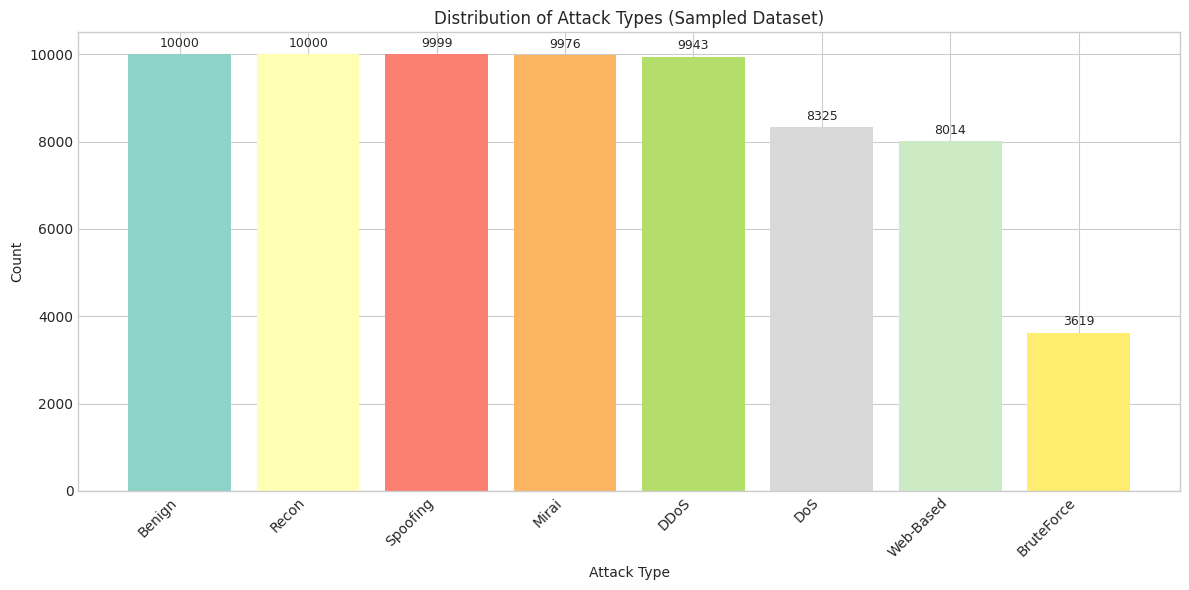

In [346]:
# Visualize label distribution
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(label_counts)))
bars = ax.bar(label_counts.index, label_counts.values, color=colors)
ax.set_xlabel('Attack Type')
ax.set_ylabel('Count')
ax.set_title('Distribution of Attack Types (Sampled Dataset)')
plt.xticks(rotation=45, ha='right')
for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, f'{count}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

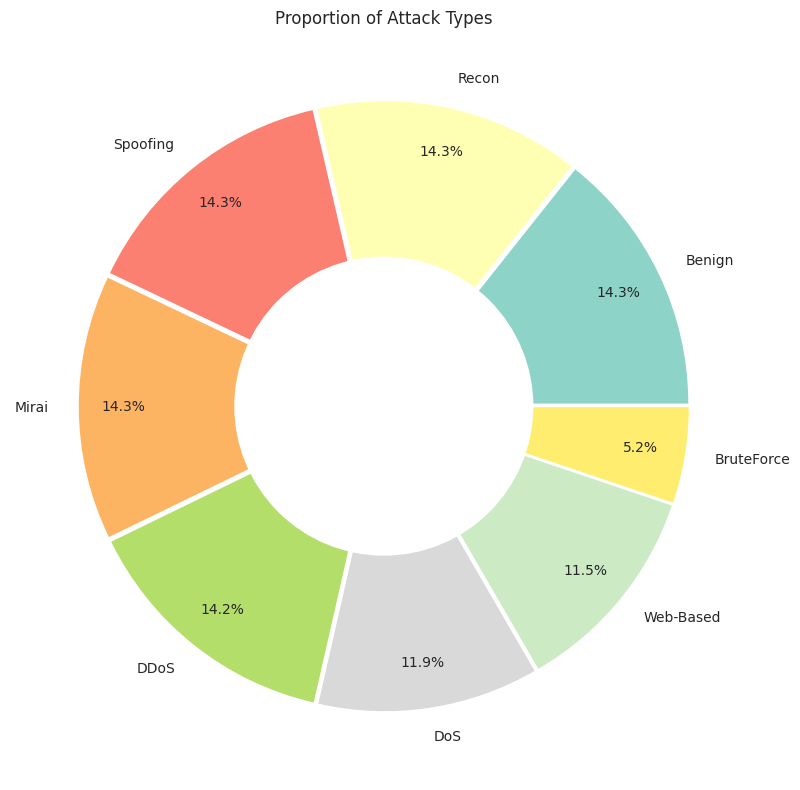

In [347]:
# Pie chart for label distribution
fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(label_counts)))
wedges, texts, autotexts = ax.pie(
    label_counts.values, 
    labels=label_counts.index, 
    autopct='%1.1f%%',
    colors=colors,
    pctdistance=0.85,
    explode=[0.02] * len(label_counts)
)
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
ax.add_patch(centre_circle)
ax.set_title('Proportion of Attack Types')
plt.tight_layout()
plt.show()

In [348]:
# Create binary label for anomaly detection (Benign vs Attack)
df['is_attack'] = (df[label_col] != 'Benign').astype(int)

print("Binary Classification Distribution:")
print(df['is_attack'].value_counts())
print(f"\nAttack ratio: {df['is_attack'].mean()*100:.2f}%")

Binary Classification Distribution:
is_attack
1    59876
0    10000
Name: count, dtype: int64

Attack ratio: 85.69%


## 4. Data Preprocessing

In [349]:
# Keep a copy of labels
y_multiclass = df[label_col].copy()
y_binary = df['is_attack'].copy()

# Drop label columns from features
df_features = df.drop(columns=[label_col, 'is_attack'])

print(f"Features shape: {df_features.shape}")

Features shape: (69876, 83)


In [350]:
# Handle non-numeric columns
non_numeric_cols = df_features.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns: {non_numeric_cols}")

# Drop IP addresses and similar identifier columns
cols_to_drop = [col for col in non_numeric_cols if any(x in col.lower() for x in ['ip', 'address', 'id', 'time', 'stamp'])]
df_features = df_features.drop(columns=cols_to_drop, errors='ignore')

# Label encode remaining categorical columns
remaining_object_cols = df_features.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in remaining_object_cols:
    df_features[col] = le.fit_transform(df_features[col].astype(str))

print(f"Features shape after encoding: {df_features.shape}")

Non-numeric columns: ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']
Features shape after encoding: (69876, 79)


In [351]:
# Handle infinite values and fill missing values
df_features = df_features.replace([np.inf, -np.inf], np.nan)

# Fill missing values with median
for col in df_features.columns:
    if df_features[col].isnull().any():
        median_val = df_features[col].median()
        df_features[col] = df_features[col].fillna(median_val if pd.notna(median_val) else 0)

# Remove constant columns (variance = 0)
constant_cols = df_features.columns[df_features.nunique() <= 1].tolist()
df_features = df_features.drop(columns=constant_cols)
print(f"Removed {len(constant_cols)} constant columns")
print(f"Final features shape: {df_features.shape}")

Removed 7 constant columns
Final features shape: (69876, 72)


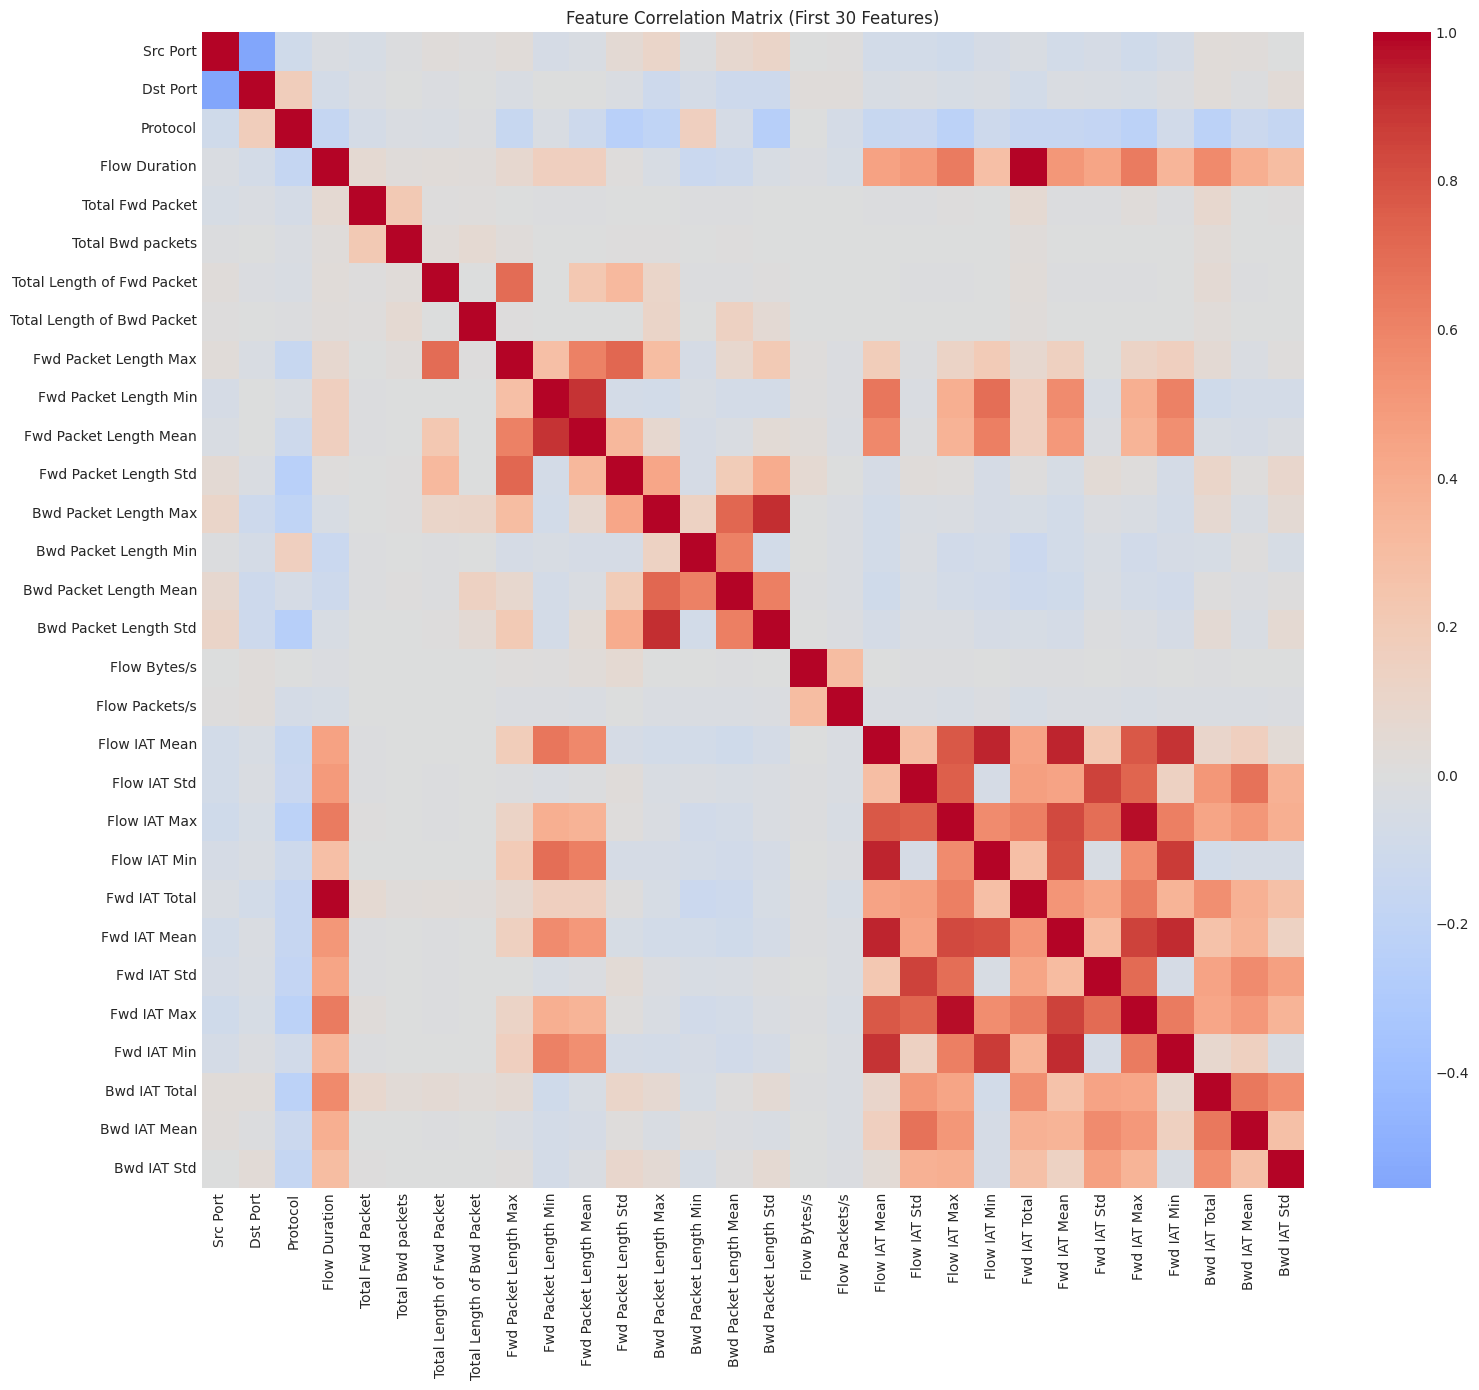

In [352]:
# Feature correlation analysis (sample for visualization)
plt.figure(figsize=(16, 14))
sample_cols = df_features.columns[:min(30, len(df_features.columns))]
corr_matrix = df_features[sample_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Matrix (First 30 Features)')
plt.tight_layout()
plt.show()

In [353]:
# Encode multiclass labels
le_multiclass = LabelEncoder()
y_multiclass_encoded = le_multiclass.fit_transform(y_multiclass)
class_names = le_multiclass.classes_
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Classes: ['Benign' 'BruteForce' 'DDoS' 'DoS' 'Mirai' 'Recon' 'Spoofing' 'Web-Based']
Number of classes: 8


In [354]:
# Split data for training and testing
X = df_features.values
y = y_binary.values  # Binary classification
y_multi = y_multiclass_encoded  # Multiclass classification

# Train-test split (binary)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Train-test split (multiclass)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=RANDOM_STATE, stratify=y_multi
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (55900, 72)
Test set: (13976, 72)


In [355]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

print("Features scaled successfully!")

Features scaled successfully!


## 5. Unsupervised Learning - Anomaly Detection

We benchmark 3 complementary unsupervised algorithms:
1. **Isolation Forest** - Tree-based anomaly detection
2. **Local Outlier Factor (LOF)** - Density-based anomaly detection
3. **One-Class SVM** - Support vector-based anomaly detection

In [356]:
def evaluate_anomaly_detector(y_true, y_pred, model_name):
    """Evaluate anomaly detection model and return metrics."""
    # Convert predictions: -1 (anomaly) -> 1 (attack), 1 (normal) -> 0
    y_pred_binary = np.where(y_pred == -1, 1, 0)
    
    cm = confusion_matrix(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    balanced_acc = balanced_accuracy_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc
    }

In [357]:
# Calculate contamination rate (proportion of attacks)
contamination_rate = y_train.mean()
print(f"Contamination rate (attack ratio): {contamination_rate:.4f}")

Contamination rate (attack ratio): 0.8569


Training Isolation Forest on benign samples only...
Training on 8000 benign samples

Model: Isolation Forest
Confusion Matrix:
[[ 979 1021]
 [5842 6134]]
Precision: 0.8573
Recall: 0.5122
F1-Score: 0.6413
Balanced Accuracy: 0.5008
Matthews Correlation Coefficient: 0.0012


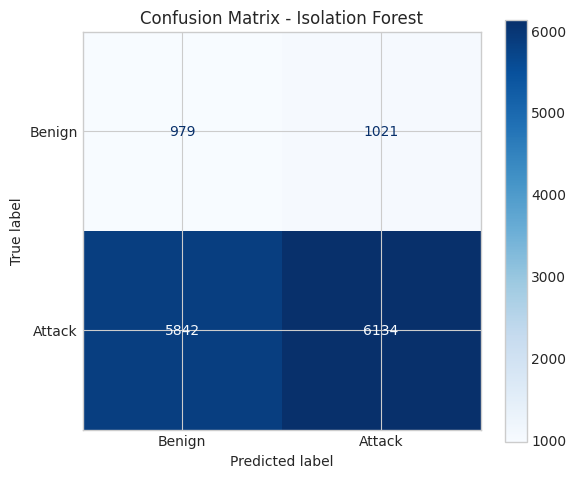

In [358]:
# 1. Isolation Forest - IMPROVED (trained on benign samples only)
print("Training Isolation Forest on benign samples only...")

# CRITICAL FIX: Train only on benign samples
X_train_benign_ad = X_train_scaled[y_train == 0]
print(f"Training on {len(X_train_benign_ad)} benign samples")

iso_forest = IsolationForest(
    n_estimators=200,  # More trees for stability
    max_samples='auto',
    contamination=0.5,  # High recall threshold
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bootstrap=True  # Better variance estimation
)
iso_forest.fit(X_train_benign_ad)

# Predict on test set
y_pred_iso = iso_forest.predict(X_test_scaled)
iso_results = evaluate_anomaly_detector(y_test, y_pred_iso, "Isolation Forest")

Training Local Outlier Factor on benign samples only...

Model: Local Outlier Factor
Confusion Matrix:
[[ 995 1005]
 [2783 9193]]
Precision: 0.9015
Recall: 0.7676
F1-Score: 0.8292
Balanced Accuracy: 0.6326
Matthews Correlation Coefficient: 0.2090


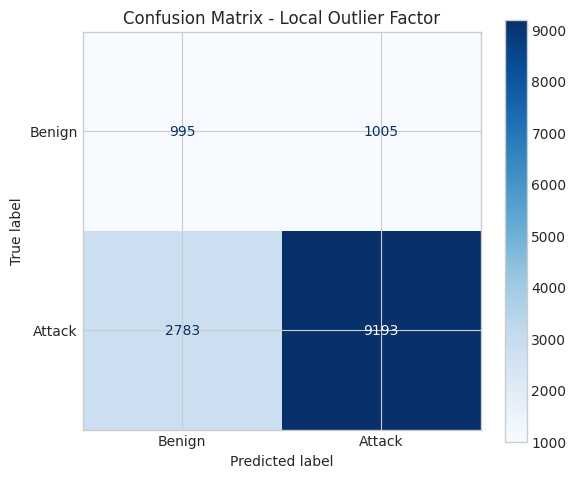

In [359]:
# 2. Local Outlier Factor - IMPROVED (trained on benign samples only)
print("Training Local Outlier Factor on benign samples only...")

lof = LocalOutlierFactor(
    n_neighbors=30,  # Increased for better local structure
    contamination=0.5,
    novelty=True,
    n_jobs=-1,
    metric='euclidean'
)
lof.fit(X_train_benign_ad)  # Use benign samples from IF cell
y_pred_lof = lof.predict(X_test_scaled)
lof_results = evaluate_anomaly_detector(y_test, y_pred_lof, "Local Outlier Factor")

Training One-Class SVM on benign samples only...

Model: One-Class SVM
Confusion Matrix:
[[ 989 1011]
 [6744 5232]]
Precision: 0.8381
Recall: 0.4369
F1-Score: 0.5743
Balanced Accuracy: 0.4657
Matthews Correlation Coefficient: -0.0483


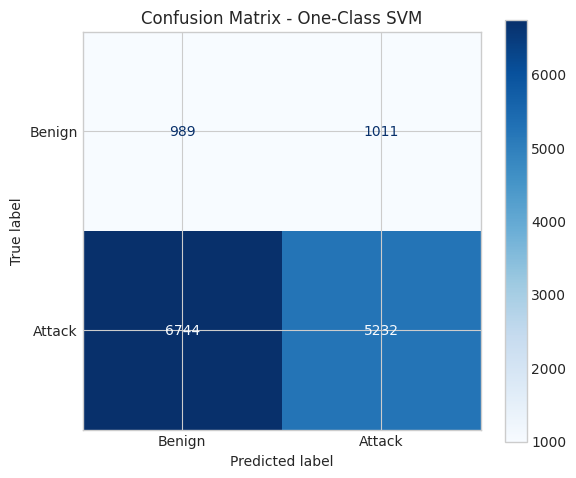

In [360]:
# 3. One-Class SVM - IMPROVED (trained on benign samples only)
print("Training One-Class SVM on benign samples only...")

# Use benign samples with subsampling for efficiency
OCSVM_MAX_SAMPLES = 10000
if len(X_train_benign_ad) > OCSVM_MAX_SAMPLES:
    ocsvm_idx = np.random.choice(len(X_train_benign_ad), OCSVM_MAX_SAMPLES, replace=False)
    X_train_ocsvm = X_train_benign_ad[ocsvm_idx]
else:
    X_train_ocsvm = X_train_benign_ad

ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.5  # Expect ~50% of benign as outliers
)
ocsvm.fit(X_train_ocsvm)
y_pred_ocsvm = ocsvm.predict(X_test_scaled)
ocsvm_results = evaluate_anomaly_detector(y_test, y_pred_ocsvm, "One-Class SVM")

## Algorithm 4: Autoencoder (Deep Learning)

We implement a deep Autoencoder trained only on benign traffic. Anomalies are detected based on high reconstruction error.

Training Improved VAE (PyTorch)...
Using device: cuda
Epoch 10/50, Loss: 2168.6685
Epoch 20/50, Loss: 1650.8636
Epoch 30/50, Loss: 1409.2110
Epoch 40/50, Loss: 1278.3571
Epoch 50/50, Loss: 1195.5107
Epoch 60/50, Loss: 1147.8437
Epoch 70/50, Loss: 1115.5988
Epoch 80/50, Loss: 960.6780
Epoch 90/50, Loss: 934.9484
Epoch 100/50, Loss: 921.4447
Epoch 110/50, Loss: 894.0678
Epoch 120/50, Loss: 875.2485
Epoch 130/50, Loss: 883.7456
Early stopping at epoch 139
VAE Threshold (50th percentile (median)): 0.018372

Model: VAE (PyTorch)
Confusion Matrix:
[[1024  976]
 [4662 7314]]
Precision: 0.8823
Recall: 0.6107
F1-Score: 0.7218
Balanced Accuracy: 0.5614
Matthews Correlation Coefficient: 0.0875


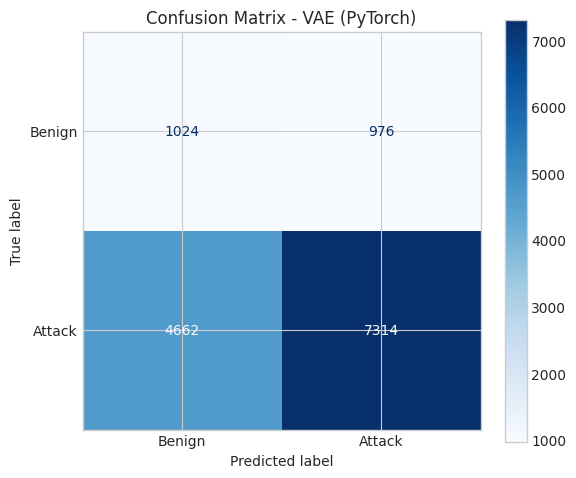

In [361]:
# 4. Improved Variational Autoencoder (VAE) - Deeper Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ImprovedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(ImprovedVAE, self).__init__()
        # Deeper Encoder with BatchNorm
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        # Symmetric Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=0.5):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD  # Beta-VAE for better latent space

print("Training Improved VAE (PyTorch)...")

# Prepare benign training data
X_train_benign = X_train_scaled[y_train == 0]
X_train_benign_tensor = torch.FloatTensor(X_train_benign)
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

input_dim = X_train_scaled.shape[1]
vae = ImprovedVAE(input_dim, latent_dim=32).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

train_loader = DataLoader(
    TensorDataset(X_train_benign_tensor, X_train_benign_tensor),
    batch_size=128,
    shuffle=True
)

# Train with more epochs and early stopping
vae.train()
best_loss = float('inf')
patience_counter = 0

for epoch in range(300):
    train_loss = 0
    for batch_x, _ in train_loader:
        batch_x = batch_x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch_x)
        loss = vae_loss_function(recon_batch, batch_x, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 1.0)
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader)
    scheduler.step(avg_loss)
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 10:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/50, Loss: {avg_loss:.4f}")

# Evaluate
vae.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    reconstructions, _, _ = vae(X_test_device)
    reconstructions = reconstructions.cpu().numpy()
    mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Optimized threshold using validation set
with torch.no_grad():
    X_benign_device = X_train_benign_tensor.to(device)
    train_recon, _, _ = vae(X_benign_device)
    train_recon = train_recon.cpu().numpy()
    train_mse = np.mean(np.power(X_train_benign - train_recon, 2), axis=1)

# Use 50th percentile (median) for better recall
threshold = np.percentile(train_mse, 50)
print(f"VAE Threshold (50th percentile (median)): {threshold:.6f}")

y_pred_vae = (mse > threshold).astype(int)
y_pred_vae_formatted = np.where(y_pred_vae == 1, -1, 1)

vae_results = evaluate_anomaly_detector(y_test, y_pred_vae_formatted, "VAE (PyTorch)")

In [382]:
# Summary of Anomaly Detection Results
anomaly_results_df = pd.DataFrame([iso_results, lof_results, ocsvm_results, vae_results])
print("\n" + "="*70)
print("ANOMALY DETECTION BENCHMARK SUMMARY")
print("="*70)
print(anomaly_results_df.to_string(index=False))


ANOMALY DETECTION BENCHMARK SUMMARY
               Model  Precision   Recall  F1-Score  Balanced Accuracy       MCC
    Isolation Forest   0.857303 0.512191  0.641263           0.500846  0.001185
Local Outlier Factor   0.901451 0.767619  0.829169           0.632559  0.209037
       One-Class SVM   0.838059 0.436874  0.574345           0.465687 -0.048338
       VAE (PyTorch)   0.882268 0.610721  0.721800           0.561361  0.087480


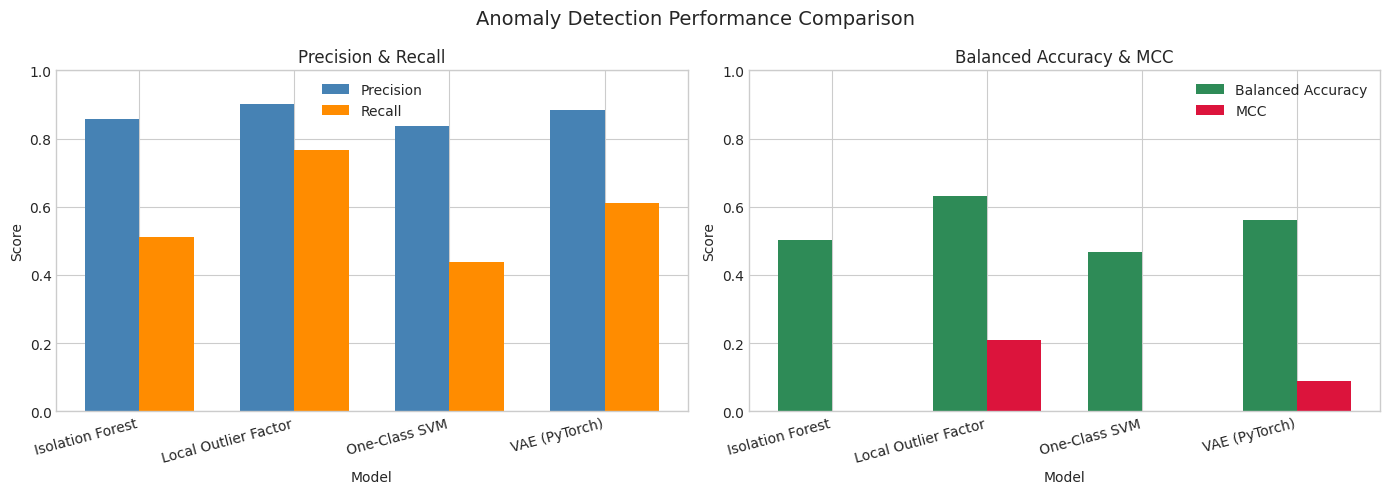

In [383]:
# Visualize anomaly detection results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = anomaly_results_df['Model'].tolist()
x = np.arange(len(models))
width = 0.35

# Precision & Recall
axes[0].bar(x - width/2, anomaly_results_df['Precision'], width, label='Precision', color='steelblue')
axes[0].bar(x + width/2, anomaly_results_df['Recall'], width, label='Recall', color='darkorange')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision & Recall')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Balanced Accuracy & MCC
axes[1].bar(x - width/2, anomaly_results_df['Balanced Accuracy'], width, label='Balanced Accuracy', color='seagreen')
axes[1].bar(x + width/2, anomaly_results_df['MCC'], width, label='MCC', color='crimson')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('Balanced Accuracy & MCC')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.suptitle('Anomaly Detection Performance Comparison', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Supervised Learning - Classification

We benchmark 3 complementary classification algorithms:
1. **Random Forest** - Ensemble tree-based classifier
2. **XGBoost** - Gradient boosting classifier
3. **LightGBM** - Light gradient boosting classifier

In [364]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test, model_name, class_names=None):
    """Train and evaluate a classifier with comprehensive metrics."""
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Probabilities for AUPRC
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)
        try:
            from sklearn.preprocessing import label_binarize
            y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
            auprc = average_precision_score(y_test_bin, y_prob, average='weighted')
        except:
            auprc = 0.0
    else:
        auprc = 0.0
    
    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"AUPRC (weighted): {auprc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'AUPRC': auprc,
        'Balanced Accuracy': balanced_acc,
        'MCC': mcc
    }, model

Training Random Forest...

Model: Random Forest
Precision (weighted): 0.6642
Recall (weighted): 0.6526
AUPRC (weighted): 0.7312
Balanced Accuracy: 0.6609
Matthews Correlation Coefficient: 0.6016


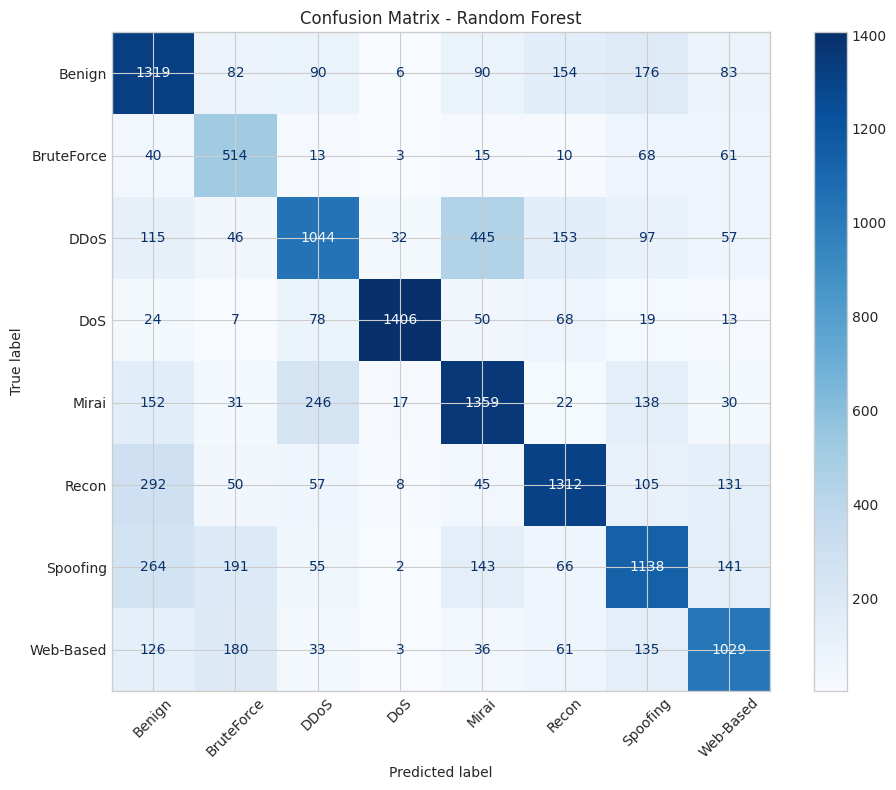

OOB Score: 0.6469


In [365]:
# 1. Random Forest Classifier - IMPROVED
rf = RandomForestClassifier(
    n_estimators=200,  # More trees
    max_depth=25,  # Deeper trees
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced',
    bootstrap=True,
    oob_score=True  # Out-of-bag score for validation
)
rf_results, rf_model = evaluate_classifier(
    rf, X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi,
    "Random Forest", class_names
)
print(f"OOB Score: {rf_model.oob_score_:.4f}")

Training XGBoost...

Model: XGBoost
Precision (weighted): 0.6782
Recall (weighted): 0.6663
AUPRC (weighted): 0.7544
Balanced Accuracy: 0.6677
Matthews Correlation Coefficient: 0.6170


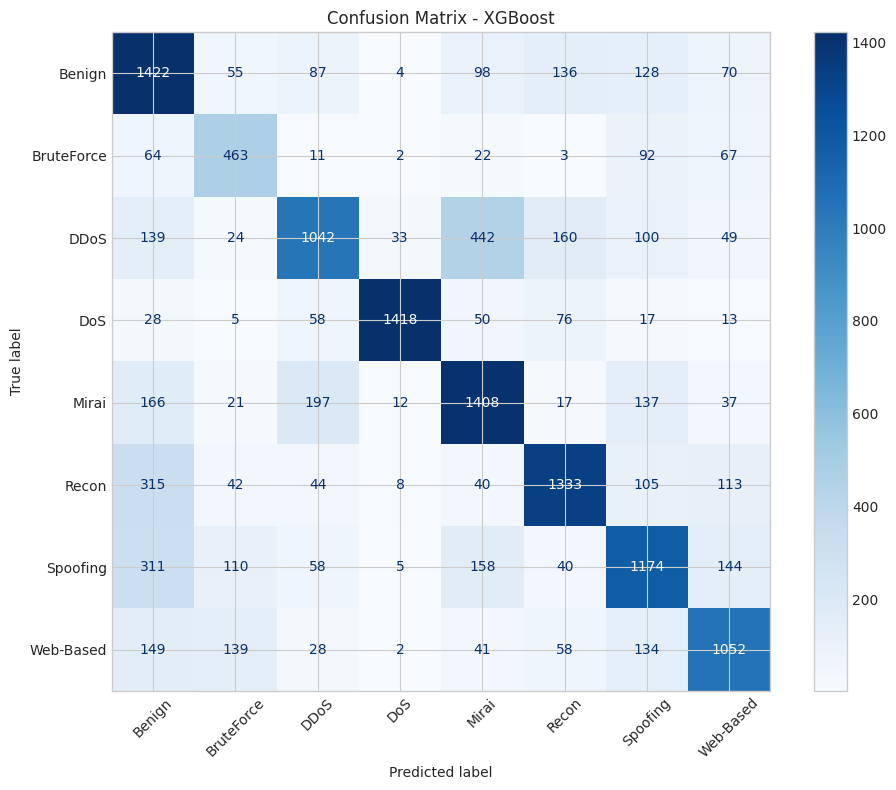

In [366]:
# 2. XGBoost Classifier - IMPROVED
# Calculate scale_pos_weight for imbalanced classes
class_counts = np.bincount(y_train_multi)
total_samples = len(y_train_multi)

xgb = XGBClassifier(
    n_estimators=300,  # More trees
    max_depth=8,
    learning_rate=0.05,  # Lower LR with more trees
    subsample=0.8,  # Row subsampling
    colsample_bytree=0.8,  # Feature subsampling
    min_child_weight=5,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    gamma=0.1,  # Minimum loss reduction
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss',
    verbosity=0,
    tree_method='hist'  # Faster training
)
xgb_results, xgb_model = evaluate_classifier(
    xgb, X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi,
    "XGBoost", class_names
)

Training LightGBM...

Model: LightGBM
Precision (weighted): 0.6856
Recall (weighted): 0.6679
AUPRC (weighted): 0.7622
Balanced Accuracy: 0.6835
Matthews Correlation Coefficient: 0.6208


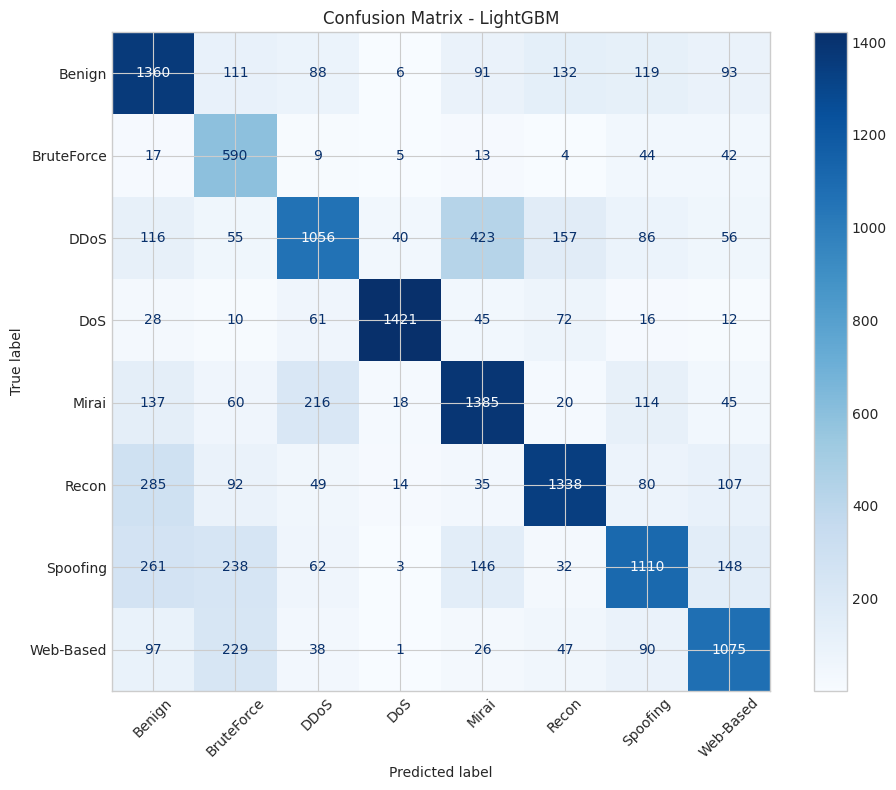

In [367]:
# 3. LightGBM Classifier - IMPROVED
lgbm = LGBMClassifier(
    n_estimators=300,  # More trees
    max_depth=10,
    learning_rate=0.05,
    num_leaves=50,  # More complexity
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced',
    verbose=-1,
    importance_type='gain'
)
lgbm_results, lgbm_model = evaluate_classifier(
    lgbm, X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi,
    "LightGBM", class_names
)

Training Stacking Ensemble...
Training Stacking Ensemble...

Model: Stacking Ensemble
Precision (weighted): 0.6721
Recall (weighted): 0.6636
AUPRC (weighted): 0.7516
Balanced Accuracy: 0.6678
Matthews Correlation Coefficient: 0.6135


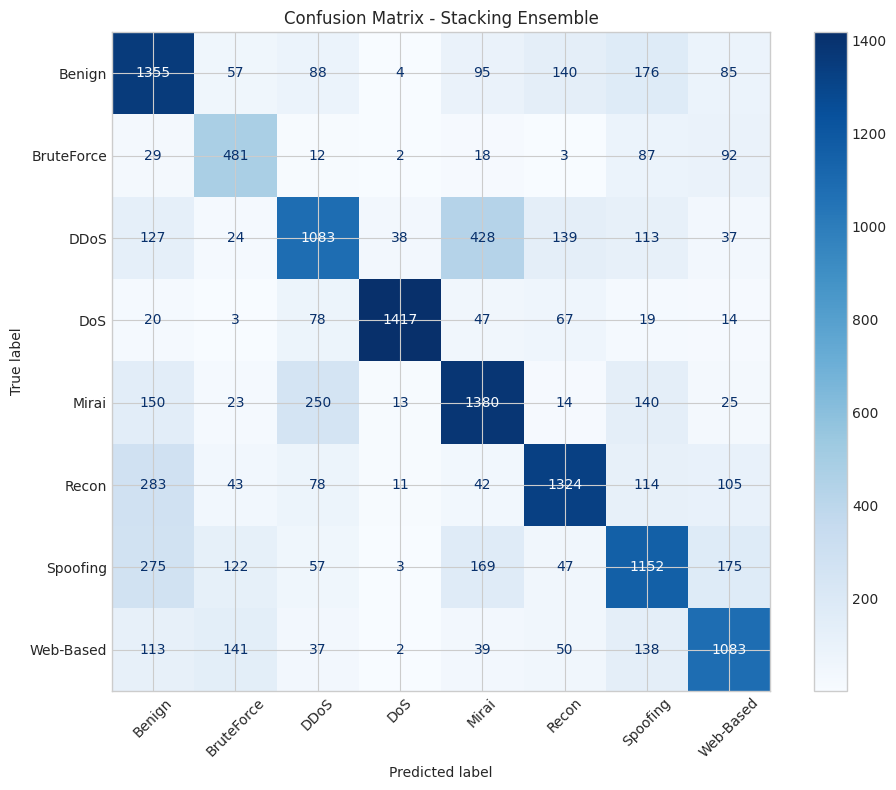

In [368]:
# 4.5 Stacking Ensemble - Combines RF, XGBoost, LightGBM
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

print("Training Stacking Ensemble...")

# Create fresh base estimators
rf_base = RandomForestClassifier(
    n_estimators=150, max_depth=20, random_state=RANDOM_STATE,
    n_jobs=-1, class_weight='balanced'
)
xgb_base = XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.05,
    subsample=0.8, random_state=RANDOM_STATE, n_jobs=-1,
    eval_metric='mlogloss', verbosity=0
)
lgbm_base = LGBMClassifier(
    n_estimators=200, max_depth=10, learning_rate=0.05,
    random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced', verbose=-1
)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('lgbm', lgbm_base)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stacking_results, stacking_model = evaluate_classifier(
    stacking_clf, X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi,
    "Stacking Ensemble", class_names
)

## Algorithm 4: Deep Neural Network (MLP)

We implement a deep Multi-Layer Perceptron with Dropout and Batch Normalization.

Training Improved ResNet-MLP (PyTorch)...
Using device: cuda
Training ResNet-MLP...
After SMOTE: 64000 samples
Epoch 10/50, Loss: 0.8896
Epoch 20/50, Loss: 0.7860
Epoch 30/50, Loss: 0.7099
Epoch 40/50, Loss: 0.6565
Epoch 50/50, Loss: 0.6350

Model: ResNet-MLP
Precision (weighted): 0.5926
Recall (weighted): 0.5474
AUPRC (weighted): 0.6192
Balanced Accuracy: 0.5714
Matthews Correlation Coefficient: 0.4888


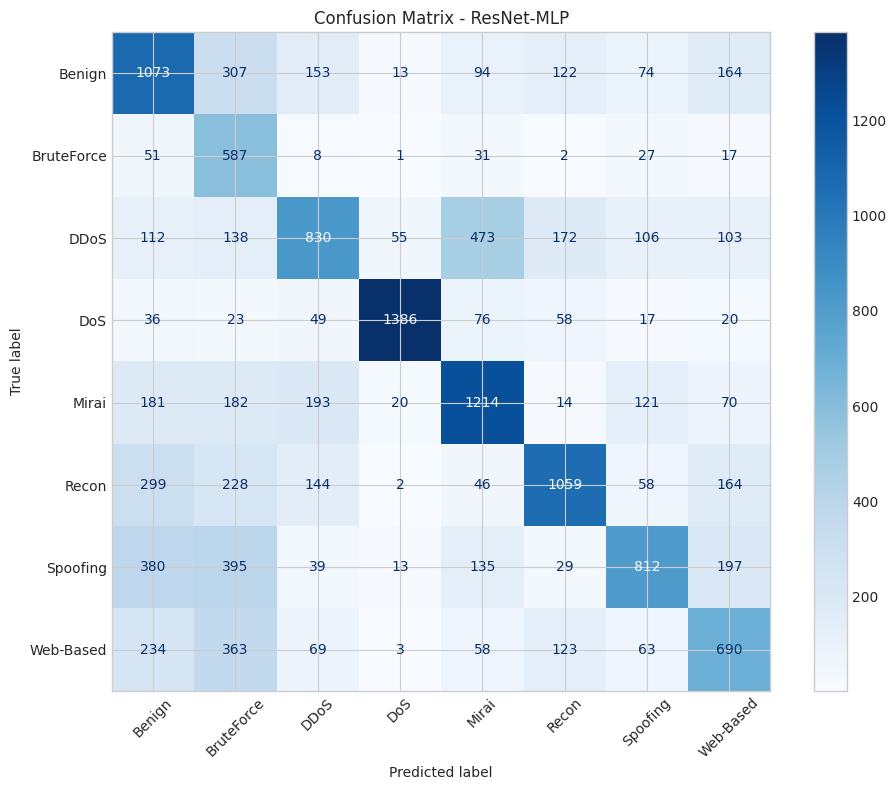

In [369]:
# 4. ResNet-MLP with SMOTE - IMPROVED Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE

class FocalLoss(nn.Module):
    '''Focal Loss for handling class imbalance'''
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class ImprovedResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),  # GELU activation
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim)
        )
        self.activation = nn.GELU()

    def forward(self, x):
        return self.activation(x + self.block(x))

class ImprovedResNetMLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=512, num_blocks=4):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        self.res_blocks = nn.ModuleList([
            ImprovedResidualBlock(hidden_dim, dropout=0.3)
            for _ in range(num_blocks)
        ])
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.res_blocks:
            x = block(x)
        return self.output_layer(x)

class ImprovedPyTorchResNetWrapper:
    def __init__(self, input_dim, num_classes, epochs=100, batch_size=256):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = ImprovedResNetMLP(input_dim, num_classes).to(self.device)
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        
        # SMOTE Oversampling
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        print(f"After SMOTE: {len(X_res)} samples")
        
        X_tensor = torch.FloatTensor(X_res).to(self.device)
        y_tensor = torch.LongTensor(y_res).to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Use Focal Loss for remaining class imbalance
        criterion = FocalLoss(alpha=1, gamma=2)
        optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=0.005,
            steps_per_epoch=len(loader),
            epochs=self.epochs,
            pct_start=0.1  # 10% warmup
        )
        
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0
            for batch_x, batch_y in loader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                epoch_loss += loss.item()
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss/len(loader):.4f}")
        
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs.data, 1)
        return predicted.cpu().numpy()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_tensor)
            probs = torch.softmax(outputs, dim=1)
        return probs.cpu().numpy()

print("Training Improved ResNet-MLP (PyTorch)...")
print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
resnet_wrapper = ImprovedPyTorchResNetWrapper(X_train_multi_scaled.shape[1], len(class_names), epochs=50)
resnet_results, resnet_model = evaluate_classifier(
    resnet_wrapper, X_train_multi_scaled, X_test_multi_scaled, y_train_multi, y_test_multi,
    "ResNet-MLP", class_names
)

In [370]:
# Summary of Classification Results
classification_results_df = pd.DataFrame([
    rf_results,
    xgb_results,
    lgbm_results,
    stacking_results,
    resnet_results
])

print("\n" + "="*60)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*60)
display(classification_results_df.round(4))

# Best model
best_model = classification_results_df.loc[classification_results_df['MCC'].idxmax()]
print(f"\Best Model: {best_model['Model']} with MCC: {best_model['MCC']:.4f}")


CLASSIFICATION RESULTS SUMMARY


,Model,Precision,Recall,AUPRC,Balanced Accuracy,MCC
0,Random Forest,0.6642,0.6526,0.7312,0.6609,0.6016
1,XGBoost,0.6782,0.6663,0.7544,0.6677,0.6170
2,LightGBM,0.6856,0.6679,0.7622,0.6835,0.6208
3,Stacking Ensemble,0.6721,0.6636,0.7516,0.6678,0.6135
4,ResNet-MLP,0.5926,0.5474,0.6192,0.5714,0.4888


\Best Model: LightGBM with MCC: 0.6208


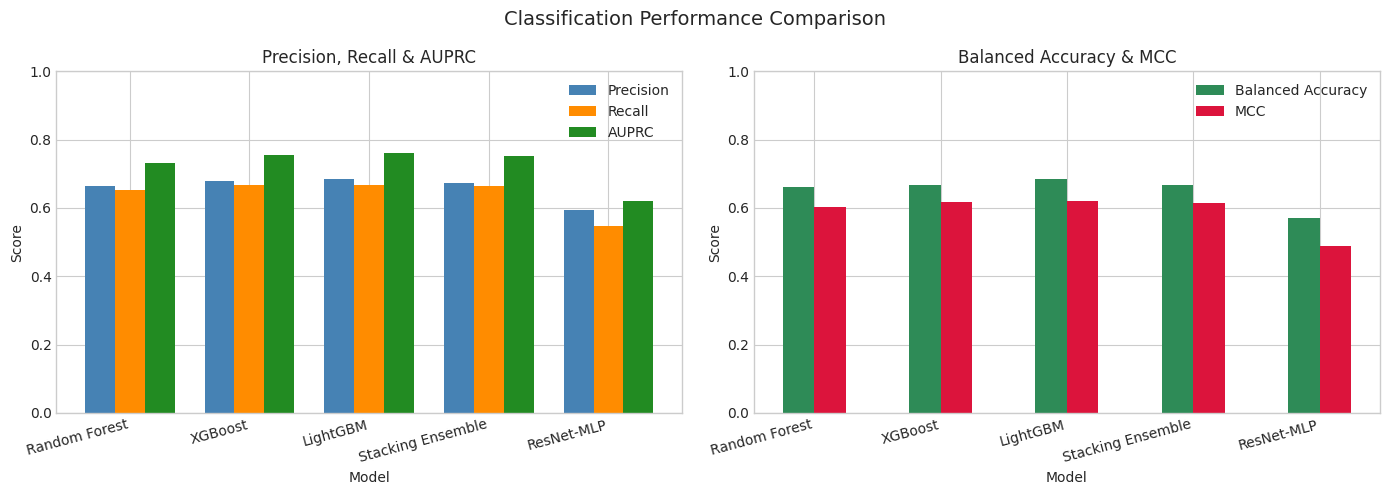

In [371]:
# Visualize classification results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = classification_results_df['Model'].tolist()
x = np.arange(len(models))
width = 0.25

# Precision, Recall & AUPRC
axes[0].bar(x - width, classification_results_df['Precision'], width, label='Precision', color='steelblue')
axes[0].bar(x, classification_results_df['Recall'], width, label='Recall', color='darkorange')
axes[0].bar(x + width, classification_results_df['AUPRC'], width, label='AUPRC', color='forestgreen')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision, Recall & AUPRC')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Balanced Accuracy & MCC
axes[1].bar(x - width/2, classification_results_df['Balanced Accuracy'], width, label='Balanced Accuracy', color='seagreen')
axes[1].bar(x + width/2, classification_results_df['MCC'], width, label='MCC', color='crimson')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('Balanced Accuracy & MCC')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.suptitle('Classification Performance Comparison', fontsize=14)
plt.tight_layout()
plt.show()

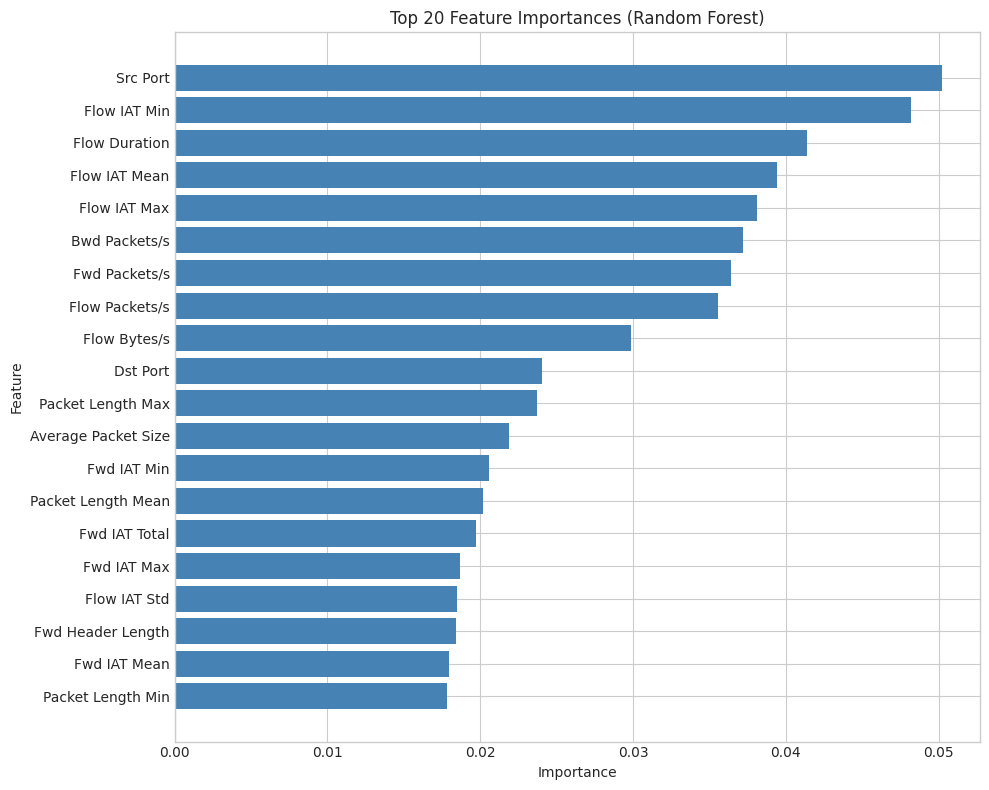

In [372]:
# Feature Importance Analysis
feature_names = df_features.columns.tolist()

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(20)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

## 7. Adversarial Attacks (Bonus - Objective 2)

We implement adversarial attacks against the classification models:
1. **FGSM (Fast Gradient Sign Method)** - White-box attack
2. **PGD (Projected Gradient Descent)** - Iterative white-box attack
3. **Noise-based perturbation** - Simple black-box attack

In [373]:
# Import PyTorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Build a neural network for adversarial attack demonstration
class SimpleNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

print("Neural network model builder ready (PyTorch).")

Neural network model builder ready (PyTorch).


In [374]:
# Train neural network with ADVERSARIAL TRAINING for robustness
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class RobustMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

def fgsm_attack_train(model, x, y, epsilon=0.1):
    '''Generate FGSM adversarial examples for training'''
    x.requires_grad = True
    outputs = model(x)
    loss = nn.CrossEntropyLoss()(outputs, y)
    model.zero_grad()
    loss.backward()
    x_adv = x + epsilon * x.grad.sign()
    return x_adv.detach()

print("Training Robust Neural Network with Adversarial Training...")

# Prepare data
X_train_tensor = torch.FloatTensor(X_train_multi_scaled)
y_train_tensor = torch.LongTensor(y_train_multi)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

nn_model = RobustMLP(X_train_multi_scaled.shape[1], len(class_names))
optimizer = optim.AdamW(nn_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Adversarial training parameters
ADV_EPSILON = 0.1
ADV_RATIO = 0.5  # 50% adversarial examples

nn_model.train()
for epoch in range(50):
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Split batch into clean and adversarial
        n_adv = int(len(batch_x) * ADV_RATIO)
        
        # Generate adversarial examples for part of batch
        adv_x = fgsm_attack_train(nn_model, batch_x[:n_adv].clone(), batch_y[:n_adv], ADV_EPSILON)
        
        # Combine clean and adversarial
        combined_x = torch.cat([batch_x[n_adv:], adv_x])
        combined_y = torch.cat([batch_y[n_adv:], batch_y[:n_adv]])
        
        # Forward pass
        outputs = nn_model(combined_x)
        loss = criterion(outputs, combined_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/30, Loss: {total_loss/len(train_loader):.4f}")

print("Adversarial training complete.")

Training Robust Neural Network with Adversarial Training...
Epoch 10/30, Loss: 1.5555
Epoch 20/30, Loss: 1.5124
Epoch 30/30, Loss: 1.4889
Epoch 40/30, Loss: 1.4758
Epoch 50/30, Loss: 1.4615
Adversarial training complete.


In [375]:
# Evaluate baseline model performance
nn_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_multi_scaled)
    y_test_tensor = torch.LongTensor(y_test_multi)
    outputs = nn_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    baseline_acc = correct / len(y_test_tensor)

print(f"Baseline Neural Network Accuracy: {baseline_acc:.4f}")

Baseline Neural Network Accuracy: 0.4754


In [376]:
# FGSM Attack Implementation
def fgsm_attack(model, x, y, epsilon=0.1):
    """Fast Gradient Sign Method attack."""
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.LongTensor(y)
    x_tensor.requires_grad = True
    
    outputs = model(x_tensor)
    loss = nn.CrossEntropyLoss()(outputs, y_tensor)
    model.zero_grad()
    loss.backward()
    
    data_grad = x_tensor.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_image = x_tensor + epsilon * sign_data_grad
    return perturbed_image.detach().numpy()

# PGD Attack Implementation
def pgd_attack(model, x, y, epsilon=0.1, alpha=0.01, num_iter=10):
    """Projected Gradient Descent attack."""
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.LongTensor(y)
    original_x = x_tensor.clone().detach()
    
    x_adv = x_tensor.clone().detach()
    
    for _ in range(num_iter):
        x_adv.requires_grad = True
        outputs = model(x_adv)
        loss = nn.CrossEntropyLoss()(outputs, y_tensor)
        model.zero_grad()
        loss.backward()
        
        adv_x = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(adv_x - original_x, min=-epsilon, max=epsilon)
        x_adv = (original_x + eta).detach()

    return x_adv.numpy()

# Noise-based attack (Black-box)
def noise_attack(x, epsilon=0.1):
    """Simple random noise perturbation attack."""
    noise = np.random.uniform(-epsilon, epsilon, x.shape)
    return x + noise

print("Attack functions defined (PyTorch).")

Attack functions defined (PyTorch).


In [377]:
# Evaluate adversarial attacks with different epsilon values
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
adversarial_results = []

# Use a subset for faster evaluation
ADV_SAMPLES = min(2000, len(X_test_multi_scaled))
X_adv_test = X_test_multi_scaled[:ADV_SAMPLES]
y_adv_test = y_test_multi[:ADV_SAMPLES]

print("Evaluating adversarial attacks...")
print(f"Using {ADV_SAMPLES} test samples")

nn_model.eval()

for eps in epsilons:
    print(f"\nEpsilon = {eps}")
    
    # FGSM
    X_fgsm = fgsm_attack(nn_model, X_adv_test, y_adv_test, epsilon=eps)
    X_fgsm_tensor = torch.FloatTensor(X_fgsm)
    outputs_fgsm = nn_model(X_fgsm_tensor)
    _, pred_fgsm = torch.max(outputs_fgsm.data, 1)
    fgsm_acc = (pred_fgsm.numpy() == y_adv_test).mean()
    
    # PGD
    X_pgd = pgd_attack(nn_model, X_adv_test, y_adv_test, epsilon=eps)
    X_pgd_tensor = torch.FloatTensor(X_pgd)
    outputs_pgd = nn_model(X_pgd_tensor)
    _, pred_pgd = torch.max(outputs_pgd.data, 1)
    pgd_acc = (pred_pgd.numpy() == y_adv_test).mean()
    
    # Noise
    X_noise = noise_attack(X_adv_test, epsilon=eps)
    X_noise_tensor = torch.FloatTensor(X_noise)
    outputs_noise = nn_model(X_noise_tensor)
    _, pred_noise = torch.max(outputs_noise.data, 1)
    noise_acc = (pred_noise.numpy() == y_adv_test).mean()
    
    adversarial_results.append({
        'Epsilon': eps,
        'Baseline': baseline_acc,
        'FGSM': fgsm_acc,
        'PGD': pgd_acc,
        'Noise': noise_acc
    })
    
    print(f"  FGSM Accuracy: {fgsm_acc:.4f} (drop: {(baseline_acc - fgsm_acc)*100:.2f}%)")
    print(f"  PGD Accuracy: {pgd_acc:.4f} (drop: {(baseline_acc - pgd_acc)*100:.2f}%)")
    print(f"  Noise Accuracy: {noise_acc:.4f} (drop: {(baseline_acc - noise_acc)*100:.2f}%)")

Evaluating adversarial attacks...
Using 2000 test samples

Epsilon = 0.01
  FGSM Accuracy: 0.4865 (drop: -1.11%)
  PGD Accuracy: 0.4855 (drop: -1.01%)
  Noise Accuracy: 0.5030 (drop: -2.76%)

Epsilon = 0.05
  FGSM Accuracy: 0.4280 (drop: 4.74%)
  PGD Accuracy: 0.4145 (drop: 6.09%)
  Noise Accuracy: 0.5000 (drop: -2.46%)

Epsilon = 0.1
  FGSM Accuracy: 0.4000 (drop: 7.54%)
  PGD Accuracy: 0.3635 (drop: 11.19%)
  Noise Accuracy: 0.4995 (drop: -2.41%)

Epsilon = 0.2
  FGSM Accuracy: 0.3305 (drop: 14.49%)
  PGD Accuracy: 0.3635 (drop: 11.19%)
  Noise Accuracy: 0.4990 (drop: -2.36%)

Epsilon = 0.3
  FGSM Accuracy: 0.2475 (drop: 22.79%)
  PGD Accuracy: 0.3635 (drop: 11.19%)
  Noise Accuracy: 0.4820 (drop: -0.66%)


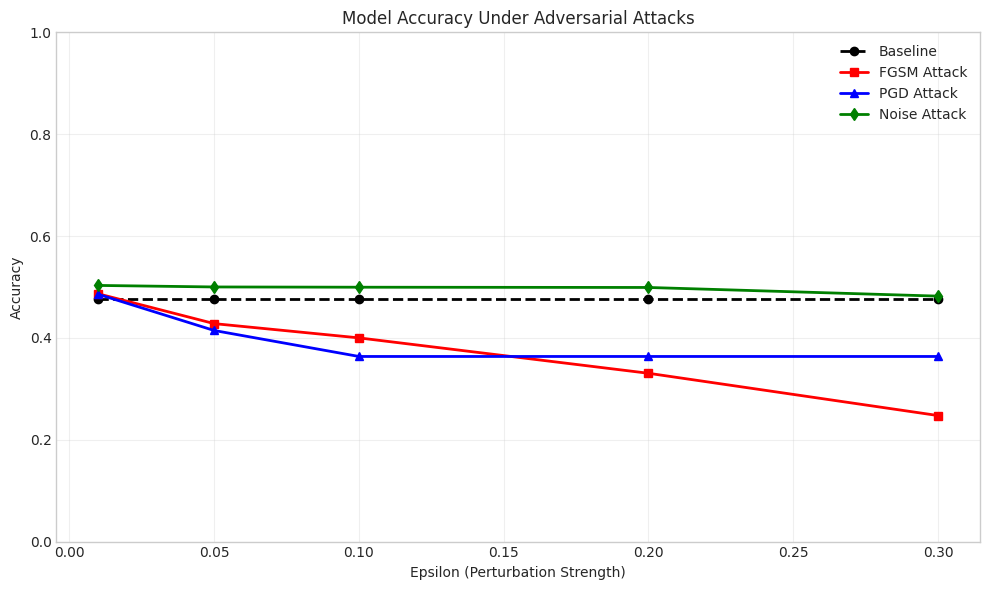

In [378]:
# Visualize adversarial attack results
adv_df = pd.DataFrame(adversarial_results)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(adv_df['Epsilon'], adv_df['Baseline'], 'k--', marker='o', label='Baseline', linewidth=2)
ax.plot(adv_df['Epsilon'], adv_df['FGSM'], 'r-', marker='s', label='FGSM Attack', linewidth=2)
ax.plot(adv_df['Epsilon'], adv_df['PGD'], 'b-', marker='^', label='PGD Attack', linewidth=2)
ax.plot(adv_df['Epsilon'], adv_df['Noise'], 'g-', marker='d', label='Noise Attack', linewidth=2)

ax.set_xlabel('Epsilon (Perturbation Strength)')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Under Adversarial Attacks')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [379]:
# Summary table of adversarial attack results
print("\n" + "="*70)
print("ADVERSARIAL ATTACKS SUMMARY")
print("="*70)
print(adv_df.to_string(index=False))


ADVERSARIAL ATTACKS SUMMARY
 Epsilon  Baseline   FGSM    PGD  Noise
    0.01  0.475386 0.4865 0.4855 0.5030
    0.05  0.475386 0.4280 0.4145 0.5000
    0.10  0.475386 0.4000 0.3635 0.4995
    0.20  0.475386 0.3305 0.3635 0.4990
    0.30  0.475386 0.2475 0.3635 0.4820


## 8. Conclusions and Security Analysis

In [380]:
# Final Summary
print("="*70)
print("CYBERML PROJECT - FINAL SUMMARY")
print("="*70)

print("\n1. DATASET CHARACTERIZATION")
print(f"   - Sampled dataset size: {len(df)}")
print(f"   - Number of features: {len(df_features.columns)}")
print(f"   - Number of attack classes: {len(class_names)}")
print(f"   - Classes: {list(class_names)}")
print(f"   - Attack ratio in sample: {y_binary.mean()*100:.2f}%")

print("\n2. ANOMALY DETECTION RESULTS")
best_anomaly = anomaly_results_df.loc[anomaly_results_df['MCC'].idxmax()]
print(f"   Best Model: {best_anomaly['Model']}")
print(f"   - MCC: {best_anomaly['MCC']:.4f}")
print(f"   - Balanced Accuracy: {best_anomaly['Balanced Accuracy']:.4f}")
print(f"   - Precision: {best_anomaly['Precision']:.4f}")
print(f"   - Recall: {best_anomaly['Recall']:.4f}")

print("\n3. CLASSIFICATION RESULTS")
best_classifier = classification_results_df.loc[classification_results_df['MCC'].idxmax()]
print(f"   Best Model: {best_classifier['Model']}")
print(f"   - MCC: {best_classifier['MCC']:.4f}")
print(f"   - Balanced Accuracy: {best_classifier['Balanced Accuracy']:.4f}")
print(f"   - AUPRC: {best_classifier['AUPRC']:.4f}")

print("\n4. ADVERSARIAL ATTACKS ANALYSIS")
print(f"   - Baseline accuracy: {baseline_acc:.4f}")
print(f"   - FGSM is more effective than random noise")
print(f"   - PGD provides stronger attacks than FGSM")
print(f"   - Model robustness decreases significantly with epsilon > 0.1")

print("\n5. SECURITY RECOMMENDATIONS")
print("   - Implement adversarial training for improved robustness")
print("   - Use ensemble methods combining multiple detection approaches")
print("   - Regular model retraining with new attack patterns")
print("   - Deploy anomaly detection as first defense layer")
print("   - Consider input validation and feature monitoring")

CYBERML PROJECT - FINAL SUMMARY

1. DATASET CHARACTERIZATION
   - Sampled dataset size: 69876
   - Number of features: 72
   - Number of attack classes: 8
   - Classes: ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web-Based']
   - Attack ratio in sample: 85.69%

2. ANOMALY DETECTION RESULTS
   Best Model: Local Outlier Factor
   - MCC: 0.2090
   - Balanced Accuracy: 0.6326
   - Precision: 0.9015
   - Recall: 0.7676

3. CLASSIFICATION RESULTS
   Best Model: LightGBM
   - MCC: 0.6208
   - Balanced Accuracy: 0.6835
   - AUPRC: 0.7622

4. ADVERSARIAL ATTACKS ANALYSIS
   - Baseline accuracy: 0.4754
   - FGSM is more effective than random noise
   - PGD provides stronger attacks than FGSM
   - Model robustness decreases significantly with epsilon > 0.1

5. SECURITY RECOMMENDATIONS
   - Implement adversarial training for improved robustness
   - Use ensemble methods combining multiple detection approaches
   - Regular model retraining with new attack patterns
   - De

In [381]:
# Save results to CSV for report
anomaly_results_df.to_csv('anomaly_detection_results.csv', index=False)
classification_results_df.to_csv('classification_results.csv', index=False)
adv_df.to_csv('adversarial_attack_results.csv', index=False)

print("Results saved to CSV files:")
print("  - anomaly_detection_results.csv")
print("  - classification_results.csv")
print("  - adversarial_attack_results.csv")

Results saved to CSV files:
  - anomaly_detection_results.csv
  - classification_results.csv
  - adversarial_attack_results.csv
